# Data Project

# 1. Data Collection
## 1.1 Importing required packages
We start off by importing the packages, that we will be using in our project.

In [1]:
import numpy as np
import pandas_datareader
import datetime
import pydst
import pandas as pd
import matplotlib.pyplot as plt

## 1.2 Importing Data
The data required for this analysis is obtained from *Danmark Statistik*.

We will be using the **NAN1** dataset from Danmarks Statistik, which contains yearly keyfigures for the danish economy from 1966-2018.

In [2]:
# Inspect variables
Dst = pydst.Dst(lang="da")
Dst.get_variables(table_id="NAN1")["values"][0][:20]

[{'id': 'B1GQK', 'text': 'B.1*g Bruttonationalprodukt, BNP'},
 {'id': 'P7K', 'text': 'P.7 Import af varer og tjenester'},
 {'id': 'P71K', 'text': 'P.71 Import af varer'},
 {'id': 'P72K', 'text': 'P.72 Import af tjenester'},
 {'id': 'TFSPR', 'text': 'Forsyning i alt'},
 {'id': 'P6D', 'text': 'P.6 Eksport af varer og tjenester'},
 {'id': 'P61D', 'text': 'P.61 Eksport af varer'},
 {'id': 'P62D', 'text': 'P.62 Eksport af tjenester'},
 {'id': 'P31S1MD', 'text': 'P.31 Privatforbrug'},
 {'id': 'P31S14D', 'text': 'P.31 Husholdningernes forbrugsudgifter'},
 {'id': 'P311AD', 'text': 'Køb af køretøjer'},
 {'id': 'P311B_3D', 'text': 'Andre varer'},
 {'id': 'P314A33S34D', 'text': 'Tjenester i alt inkl. turisme'},
 {'id': 'P314D', 'text': 'Tjenester i alt'},
 {'id': 'P33D', 'text': 'Turistudgifter'},
 {'id': 'P34D', 'text': 'Turistindtægter'},
 {'id': 'P31S15D',
  'text': 'P.31 Forbrugsudgifter i non-profit institutioner rettet mod husholdninger (NPISH)'},
 {'id': 'P3S13D', 'text': 'P.3 Offentlige f

By using the information obtaoined from `Dst.get_variables(table_id="NAN1")["values"][0][:20]` we are able to import the variables of interest.

Each imported variable from NAN1 is assigned a variable that we can call upon later in our code. We import the full time range and the values are given in 2010-prices

In [3]:
#Importing desired variables from NAN1
gdp = Dst.get_data(table_id = "NAN1", variables = {"TRANSAKT":["B1GQK"], "PRISENHED":["LAN_M"], "Tid":["*"]})
priv_cons = Dst.get_data(table_id = "NAN1", variables = {"TRANSAKT":["P31S1MD"], "PRISENHED":["LAN_M"], "Tid":["*"]})
publ_cons = Dst.get_data(table_id = "NAN1", variables = {"TRANSAKT":["P3S13D"], "PRISENHED":["LAN_M"], "Tid":["*"]})
inv = Dst.get_data(table_id = "NAN1", variables = {"TRANSAKT":["P51GD"], "PRISENHED":["LAN_M"], "Tid":["*"]})
exp = Dst.get_data(table_id = "NAN1", variables = {"TRANSAKT":["P6D"], "PRISENHED":["LAN_M"], "Tid":["*"]})
imp = Dst.get_data(table_id = "NAN1", variables = {"TRANSAKT":["P7K"], "PRISENHED":["LAN_M"], "Tid":["*"]})

## 1.3 Cleaning and preparing data
We will now create lists containing our variables from previous section. These will be used later, in our loops.

In [4]:
variable_list = ("B1GQK", "P31S1MD", "P3S13D", "P51GD", "P6D", "P7K")
var_list = (gdp, priv_cons, publ_cons, inv, exp, imp)
var_list_string = ("gdp", "priv_cons", "publ_cons", "inv", "exp", "imp")

for i in var_list:
        """The loop below drops the unwanted columns from the var_list variables for the purpose of cleaning the dataset
        """
        i.drop(["TRANSAKT", "PRISENHED"], axis = 1, inplace = True)
    
for i in var_list:
        """We can now index our data on time, this will ensure that it is treated as time-series.
        """
        i.index = i["TID"]

Now, when inspecting our data, we observe that the column names are the same for each variables.

In [5]:
print(gdp.head()); print(inv.head())

       TID INDHOLD
TID               
1991  1991  1306,6
1992  1992  1332,2
2018  2018  2050,5
1993  1993  1332,3
1994  1994  1403,3
       TID INDHOLD
TID               
1990  1990   221,5
1991  1991   216,3
2018  2018   451,4
1992  1992   215,2
1993  1993   209,5


We can fix the above issue by renaming the columns for our variables. This is done by using the `.rename()` on the Dataframe. It takes the the original column name as input and transform it to desired output

In [6]:
# Rename variables

gdp = gdp.rename(columns = {"TID":"year", "INDHOLD":"gdp"})
priv_cons = priv_cons.rename(columns = {"TID":"year", "INDHOLD":"priv_cons"})
publ_cons = publ_cons.rename(columns = {"TID":"year", "INDHOLD":"publ_cons"})
inv = inv.rename(columns = {"TID":"year", "INDHOLD":"inv"})
exp = exp.rename(columns = {"TID":"year", "INDHOLD":"exp"})
imp = imp.rename(columns = {"TID":"year", "INDHOLD":"imp"})
"""Dataframe.rename(colums = {"original name":"new name"})
"""

'Dataframe.rename(colums = {"original name":"new name"})\n'

# 2. Creating a single dataframe
We will now construct a single dataframe, indexed on *time*, containing all necessary variables to be used in our analysis.

Using the `pd.DataFrame()` function to create an empty pandas dataframe, containing only a time index. This will make it easier to merge all sub-dataframes into a single dataframe.

In [7]:
# Create empty dataframe
data = pd.DataFrame(index=range(1966,2019), columns = ["year"])

# Specify index
data["year"] = range(1966, 2019)

# View empty frame
data.head()

,year
1966,1966
1967,1967
1968,1968
1969,1969
1970,1970


We use the `pandas.merge()` function to merge every subset of our data into a single dataframe.

The function merges two dataframes together. It takes the names of the two dataframes as inputs, as well as a specification of how they should be merged i.e. "inner" in our case and on what reference column i.e. "year" in our case

As we can only merge two dataframes at a time we do multiple partial
merges to combine all our sub-dataframes into a single one

In [8]:
# Merge Dataset

data = pd.merge(data, gdp, how = "inner", on = ["year"])
""" how explains the type of merge, while on specifies the column we reference to
"""

data = pd.merge(data, priv_cons, how = "inner", on = ["year"])
data = pd.merge(data, publ_cons, how = "inner", on = ["year"])
data = pd.merge(data, inv, how = "inner", on = ["year"])
data = pd.merge(data, exp, how = "inner", on = ["year"])
data = pd.merge(data, imp, how = "inner", on = ["year"])

# View first five rows of dataframe
data.head()

,year,gdp,priv_cons,publ_cons,inv,exp,imp
0,1966,"702,4","372,8","171,3","114,7","123,6","112,2"
1,1967,"741,2","397,9","185,0","124,5","128,2","120,0"
2,1968,"782,4","412,2","195,7","130,6","140,7","127,7"
3,1969,"833,3","435,8","209,4","147,0","149,2","144,0"
4,1970,"846,6","446,6","222,3","151,3","154,9","157,2"


## 2.1 Preparing dataframe for analysis
We will now be cleaning our data, in order to prepare it for analysis.

We start off by indexing our final dataframe on "*year*" and deleting the `year` column, as this is no longer of use:

In [9]:
# Indexing on time
data.index = data["year"]

# Delete "year" column
del data["year"]

data.head()

,gdp,priv_cons,publ_cons,inv,exp,imp
year,,,,,,
1966,"702,4","372,8","171,3","114,7","123,6","112,2"
1967,"741,2","397,9","185,0","124,5","128,2","120,0"
1968,"782,4","412,2","195,7","130,6","140,7","127,7"
1969,"833,3","435,8","209,4","147,0","149,2","144,0"
1970,"846,6","446,6","222,3","151,3","154,9","157,2"


As we are only interested in values from 1980 to 2018, we will be removing the rows up to the year 1980.

This is done with the `pandas.loc()` function and stored on the existing dataset as below:

In [10]:
data = data.loc[1980 :]

data.head()

,gdp,priv_cons,publ_cons,inv,exp,imp
year,,,,,,
1980,"1048,1","538,8","310,2","159,8","245,3","211,9"
1981,"1041,2","532,0","318,3","133,1","266,5","213,1"
1982,"1079,5","539,5","328,8","144,1","275,0","219,8"
1983,"1107,5","549,9","328,6","150,5","287,6","224,1"
1984,"1153,7","569,2","323,1","166,0","297,1","236,1"


We will now convert the comma-separator from "," to ".", as python does not use "," as comma-separator:

In [11]:
# Correcting for comma separator and conver to floats

for i in var_list_string:
        """ This code is designed in order to change comma-separator
        """
        data[i] = data[i].replace(",",".", regex=True)
        """ This converts the variables from "strings" to "floats"
        """
        data[i] = data[i].astype(float)
        
data.head()

,gdp,priv_cons,publ_cons,inv,exp,imp
year,,,,,,
1980,1048.1,538.8,310.2,159.8,245.3,211.9
1981,1041.2,532.0,318.3,133.1,266.5,213.1
1982,1079.5,539.5,328.8,144.1,275.0,219.8
1983,1107.5,549.9,328.6,150.5,287.6,224.1
1984,1153.7,569.2,323.1,166.0,297.1,236.1


## 2.2 Adding additional variables

For our analysis, variables as *Import* and *Export*, can just be summarized as *Net exports*, which is defined as:

$$Net\,export=Export-Import$$

We will now construct a new variable in our data frame named ```nx``` which captures Gross Net Exports, 2010-chained value (billion kr.)

In [12]:
# Create new column named nx, denoting netexports by subtracting export from import
data["nx"] = data["exp"] - data["imp"]

# We assign the new column to a variable, nx, which will be used in later analysis
nx = data["nx"]

We will now add the respective percentage change for all variables in ```data```, to our dataset. The percentage changes are usefull when conducting analysis and are calulated as follows:

$${pct\,change\,in\,x} = \frac{x_t-x_{t-1}}{x_{t-1}}*100$$

In [13]:
# Update var_list and var_list_string to include "nx"
var_list = (gdp, priv_cons, publ_cons, inv, exp, imp, nx)
var_list_string = ("gdp", "priv_cons", "publ_cons", "inv", "exp", "imp", "nx")

# Generate percentage change of variables
data_pct_change = data.pct_change()
data_pct_change = data_pct_change * 100 # in order to obtain percentage values

# Rename columns to indicate percentage change
for i in var_list_string:
        data_pct_change = data_pct_change.rename(columns = {i:"pct. change in "+i})

# Merge dataset with original dataset
data = pd.merge(data, data_pct_change, how = "inner", on = ["year"])

round(data.head(), 1)

,gdp,priv_cons,publ_cons,inv,exp,imp,nx,pct. change in gdp,pct. change in priv_cons,pct. change in publ_cons,pct. change in inv,pct. change in exp,pct. change in imp,pct. change in nx
year,,,,,,,,,,,,,,
1980,1048.1,538.8,310.2,159.8,245.3,211.9,33.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981,1041.2,532.0,318.3,133.1,266.5,213.1,53.4,-0.7,-1.3,2.6,-16.7,8.6,0.6,59.9
1982,1079.5,539.5,328.8,144.1,275.0,219.8,55.2,3.7,1.4,3.3,8.3,3.2,3.1,3.4
1983,1107.5,549.9,328.6,150.5,287.6,224.1,63.5,2.6,1.9,-0.1,4.4,4.6,2.0,15.0
1984,1153.7,569.2,323.1,166.0,297.1,236.1,61.0,4.2,3.5,-1.7,10.3,3.3,5.4,-3.9


# 3. Presenting data

We will now visually analyse the development of the GDP components, in order to see how these have changed compared to GDP.
We start off by comparing the weights of each GDP component from 1980 and 2018 in order to see if anything has changed.

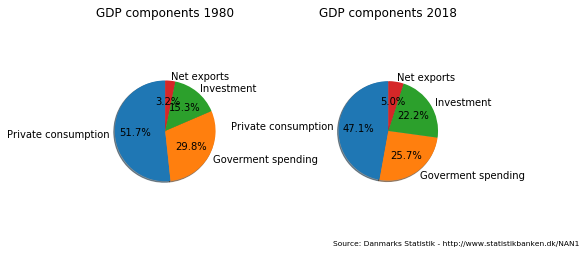

In [14]:
# calculations for piechart to compare compomnents in 1980 to 2018
sizes_1980 = [data.loc[1980, "priv_cons"], data.loc[1980, "publ_cons"], data.loc[1980, "inv"], data.loc[1980, "nx"]]
sizes_2018 = [data.loc[2018, "priv_cons"], data.loc[2018, "publ_cons"], data.loc[2018, "inv"], data.loc[2018, "nx"]]

labels = ["Private consumption", "Goverment spending", "Investment", "Net exports"]

fig1, ax = plt.subplots(1,2)
plt.style.use("tableau-colorblind10") #This is for cosmetic purposes

# 1980
ax[0].pie(sizes_1980, labels = labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title("GDP components 1980")

#2018
ax[1].pie(sizes_2018, labels = labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[1].axis('equal')
ax[1].set_title("GDP components 2018")

#adjustments
plt.subplots_adjust(wspace=1)

#add source
plt.annotate('Source: Danmarks Statistik - http://www.statistikbanken.dk/NAN1', (0,0), (0,0), fontsize = 7.5, xycoords = 'axes fraction', textcoords = 'offset points', va = 'top')

plt.show()

We observe that there has not been any significant changes to the components as pct. of GDP. Investments have now increased as pct. of GDP, from 15.3 % in 1980 to 22.2 % in 2018, whilst Net exports have increased from 3.2 % to 5 %. Private consumption, was 51.7 % but is now 47.1 %, whilst goverment spending has fallen from 29.8 % to 25.7 %.

As we will see next, this is not due to a lack of change in the respective component, as there has been an overall increase in GDP and all of its components.

We will now analyse the change in the respective components and will compare it to the increase in Gross Domestic Product.
We define a function, in order to reduce the repetetive task of making new figures for each variable. We will show later what the function does.

In [66]:
def my_graph(var1, varname1, var2 = "gdp", varname2 = "GDP", df = data):
    """
    df - a pandas dataframe containing the variables
    
    var1 - a string character that indicates the first variable of choice in our dataframe
    var2 - a string character that indicates the second variable of choice in our dataframe
    
    varname1 - a string character that indicates what we want the first variable to be called
    varname1 - a string character that indicates what we want the second variable to be called
    """
    
    fig, ax = plt.subplots(1, 2)
    plt.style.use("tableau-colorblind10")
    
    # Figure 1
    ax[0].plot(df.index,df[var2], linestyle = "--")
    ax[0].twinx().plot(df.index, df[var1])
    
    ax[0].set_xlabel("Years")
    ax[0].set_ylabel(varname2+" (Billion DKK)")
    ax[0].twinx().set_ylabel(varname1+" (Billions DKK)")
    ax[0].set_title(varname2+" and "+varname1)
    
    ax[0].legend(loc = 4, frameon = False)
    ax[0].twinx().legend(loc = 8, frameon = False)
    
    # Figure 2
    ax[1].plot(df.index,df["pct. change in "+var2], linestyle = "--")
    ax[1].twinx().plot(df.index, df["pct. change in "+var1])
    
    ax[1].set_xlabel("Years")
    ax[1].set_ylabel(varname2+" (growth rate)")
    ax[1].twinx().set_ylabel(varname1+" (growth rate)")
    ax[1].set_title(varname2+" and "+varname1)
    
    ax[1].legend(loc = 4, frameon = False)
    ax[1].twinx().legend(loc = 8, frameon = False)
    
    #Adjust size of plot
    plt.subplots_adjust(right = 2, wspace = 0.5, hspace = 0)
    
    #make annotation for source
    plt.annotate('Source: Danmarks Statistik - http://www.statistikbanken.dk/NAN1', (0,0), (0,-45), fontsize = 7.5, 
             xycoords = 'axes fraction', textcoords = 'offset points', va = 'top')
    
    plt.show()

We will also create a table containing key statistics about the growth of GDP and its key components. This table will containg the percentage change in the components and the average annual growth rate. The statistics are computed below.

In [67]:
#Pct change from 1980 to 2018
stats = round((((data.loc[2018]-data.loc[1980])/data.loc[1980])*100), 2)
stats = stats.dropna()
stats = pd.DataFrame(stats, columns = ["Pct. increase"])

# average pct increase
stats["Average pct. increase"] = [np.mean(data["pct. change in gdp"]), np.mean(data["pct. change in priv_cons"]), np.mean(data["pct. change in publ_cons"]), np.mean(data["pct. change in inv"]), np.mean(data["pct. change in exp"]), np.mean(data["pct. change in imp"]), np.mean(data["pct. change in nx"])]
stats["Average pct. increase"] = round(stats["Average pct. increase"],2)

stats.rename(index={"gdp":"Gross Domestic Product"}, inplace=True)
stats.rename(index={"priv_cons":"Private Consumption"}, inplace=True)
stats.rename(index={"publ_cons":"Goverment Expenditure"}, inplace=True)
stats.rename(index={"inv":"Investment"}, inplace=True)
stats.rename(index={"exp":"Export"}, inplace=True)
stats.rename(index={"imp":"Import"}, inplace=True)
stats.rename(index={"nx":"Net Export"}, inplace=True)

# Beginning value and end value
val_1980 = [data.loc[1980, "gdp"], data.loc[1980, "priv_cons"], data.loc[1980, "publ_cons"], data.loc[1980, "inv"], data.loc[1980, "exp"], data.loc[1980, "imp"], data.loc[1980, "nx"]]
val_2018 = [data.loc[2018, "gdp"], data.loc[2018, "priv_cons"], data.loc[2018, "publ_cons"], data.loc[2018, "inv"], data.loc[2018, "exp"], data.loc[2018, "imp"], data.loc[2018, "nx"]]

stats["1980 (bn DKK)"] = val_1980
stats["2018 (bn DKK)"] = val_2018

stats

,Pct. increase,Average pct. increase,1980 (bn DKK),2018 (bn DKK)
Gross Domestic Product,95.64,1.80,1048.1,2050.5
Private Consumption,77.95,1.55,538.8,958.8
Goverment Expenditure,68.41,1.39,310.2,522.4
Investment,182.48,3.00,159.8,451.4
Export,375.13,4.26,245.3,1165.5
Import,402.36,4.45,211.9,1064.5
Net Export,202.40,4.60,33.4,101.0


## 3.1 Private consumption

No handles with labels found to put in legend.
No handles with labels found to put in legend.


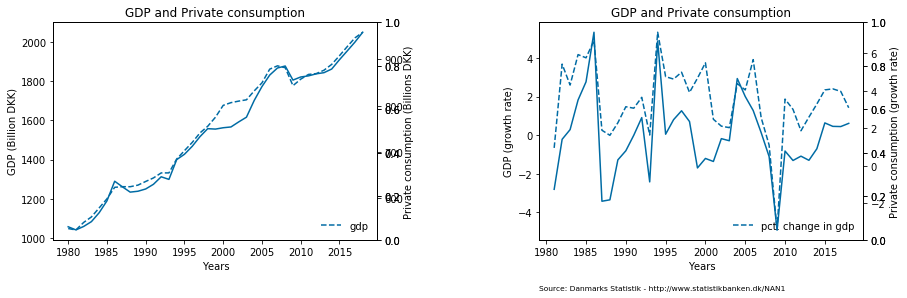

In [68]:
my_graph("priv_cons", "Private consumption")

Consumption has increased from 538.8 billion DKK in 1980 to 958.8 billion DKK in 2018. This translates to an increase of 77.95 % during the entire period, with an average annual growth rate of 1.55 %. GDP went from 1048.1 billion DKK to 2050.5 billion DKK, thus increasing by 95.64 %, during the entire period, meaning an average annual growth rate of 1.8 %.

As the figure above shows, the increase in consumption has closely followed that of GDP, with the exception of 1997-2003, where investments seemed to stall, while GDP increased. Both show significant increase during the entire period, except for a few drops in consumption in 1987, 1994 and a larger drop around the period of the 2008 financial crisis.

## 3.2 Goverment expenditure

No handles with labels found to put in legend.
No handles with labels found to put in legend.


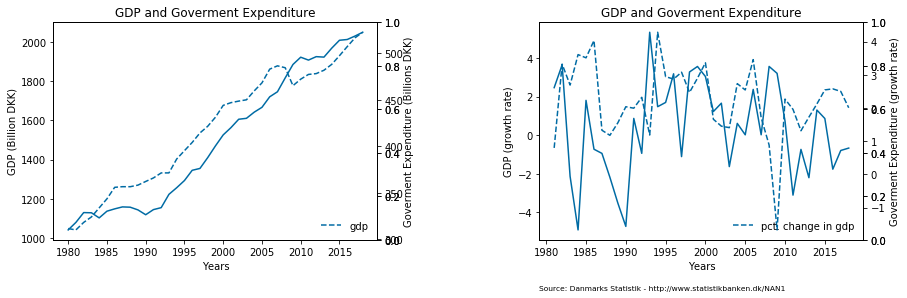

In [69]:
my_graph("publ_cons", "Goverment Expenditure")

Government expenditure has increased from 310.2 billion DKK in 1980 to 522.4 billion DKK in 2018, this is an overall total increase of 68.41 %, with an average growth rate of 1.39 % per year. Again, an increase in GDP and Public spending both follow the same development during the time period.

We see that the only period where this is nor true, is in the 2008, where GDP drops, but goverment spending increases. This might be partially due to fiscal policy.

## 3.3 Investment

No handles with labels found to put in legend.
No handles with labels found to put in legend.


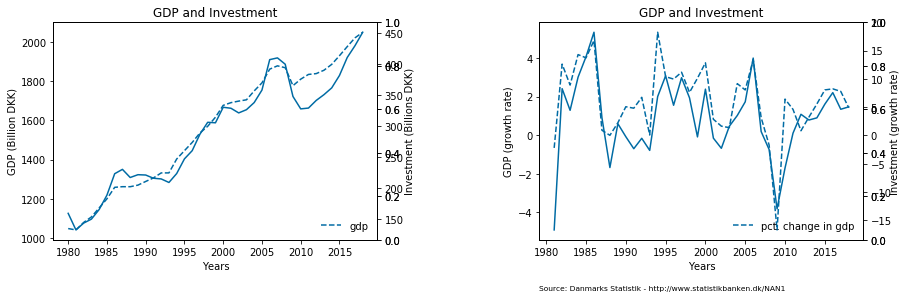

In [72]:
my_graph("inv", "Investment")

Investments have increased significantly during the period. Gross investments have increased from 259.8 billion DKK in 1980 to 451.4 billion DKK, a total increase of 182.48 %, an average growth rate of 3 %. We also saw earlier that investments make up 22.2 % of GDP, thus showcasing the change in the danish economy in regards to investments.

Investments did drop significantly during the late 80's and early 90's, as well as during the financial crisis of 2008, dropping by 15 %. They have, however, seemed to increase from thereon and are currently on their highest ever.

## 3.4 Net Exports

### 3.4a Export and Import

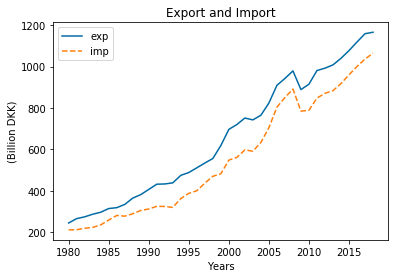

In [75]:
fig, ax = plt.subplots()
plt.style.use("tableau-colorblind10")


ax.plot(data.index,data["exp"])
ax.plot(data.index,data["imp"], linestyle = "--")

ax.set_title("Export and Import")
ax.set_xlabel("Years")
ax.set_ylabel("(Billion DKK)")

ax.legend()
plt.show()

The figure above shows the change in export and import from 1980-2018. Exports have increased from 245.3 billion DKK in 1980 to 1165.5 billion DKK. This corresponds to a staggering 375.13 % increase in exports in a (roughly) 30 year period. This increase in exports is accompanied with an even larger increase in imports, which has gone from 211.9 billion DKK to 1064.5 billion DKK in 2018, an increase of 402.36 %. These numbers show an overwhelming increase in trade. We will next examine the chnage in the trade decifit (net exports) during the same period.

### 3.4b Net Exports

No handles with labels found to put in legend.
No handles with labels found to put in legend.


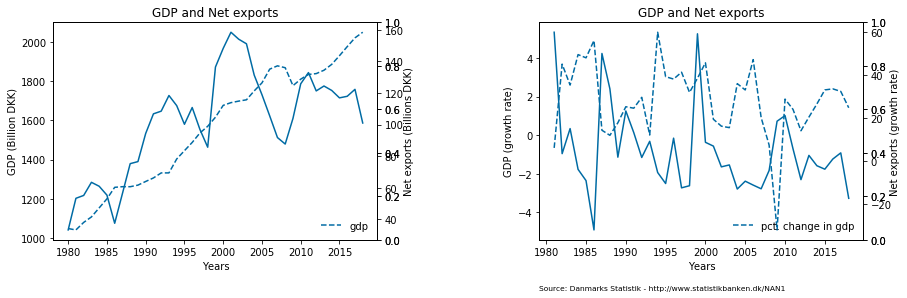

In [79]:
my_graph("nx", "Net exports")

Net exports has gone from 33.4 billion DKK in 1980 to 101 billion DKK in 2018, corresponding to a 202.4 % increase, with an average annual growth of 4.6 %. These are impressive numbers considering the short time-petiod and shows an overall progress in the danish economy as a whole.

# 4. Conclusion

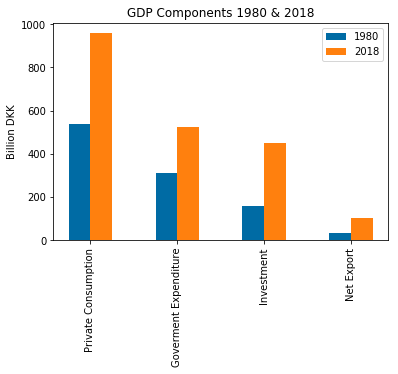

In [129]:
# Drop non-used variables
stats2 = stats.drop(["Gross Domestic Product", "Export", "Import"])

# Figure
fig, ax = plt.subplots()
plt.style.use("tableau-colorblind10")

# Define Bars
ax.bar(stats2.index, stats2["1980 (bn DKK)"], label = "1980", width = 0.5)
ax.bar(stats2.index, stats2["2018 (bn DKK)"], label = "2018", width = 0.25, align = "edge")

# Axis Labels
ax.set_xticklabels(stats2.index, rotation = 90) #Rotating x-axis labels if long names
ax.set_ylabel("Billion DKK")

ax.set_title("GDP Components 1980 & 2018")
ax.legend()

plt.show()

As the figure above shows, all the components have increased significantly from 1980 to 2018, as it is to be expected from a developed country. Private consumption has nearly doubled, while goverment expenditure has increased by nearly 70 %. Investment (182.48 %) and Net Exports (202.4 %) have both nearly doubled in value. In this period, the dansih gross domestic product has increased by 95.64 %. The danish GDP is in 2018 a staggering 2050.5 billion DKK. Even though periods of recession have incured, the danish economy has been progressing rapidly.